This notebook will contain non-nodal results, ideally comparing the networks of the ASD population against the neurotypical.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
data = pd.read_csv("master_data_cc400.csv")

filtered_data = data[data['Age'] >= 18]
filtered_data = filtered_data[filtered_data['Age'] <= 30]

filtered_data_asd = filtered_data[filtered_data['DX_Group'] == 1]
filtered_data_nt = filtered_data[filtered_data['DX_Group'] == 2]

condensed_df_asd = filtered_data_asd.drop_duplicates(subset=["Participant ID"], keep="first")
condensed_df_nt = filtered_data_nt.drop_duplicates(subset=["Participant ID"], keep="first")
print(len(condensed_df_asd))
print(len(condensed_df_nt))

# filtered_data_asd = 


print(filtered_data_nt['Age'].mean())



55
74
22.98297297297297


__Phenotypic Demographics__

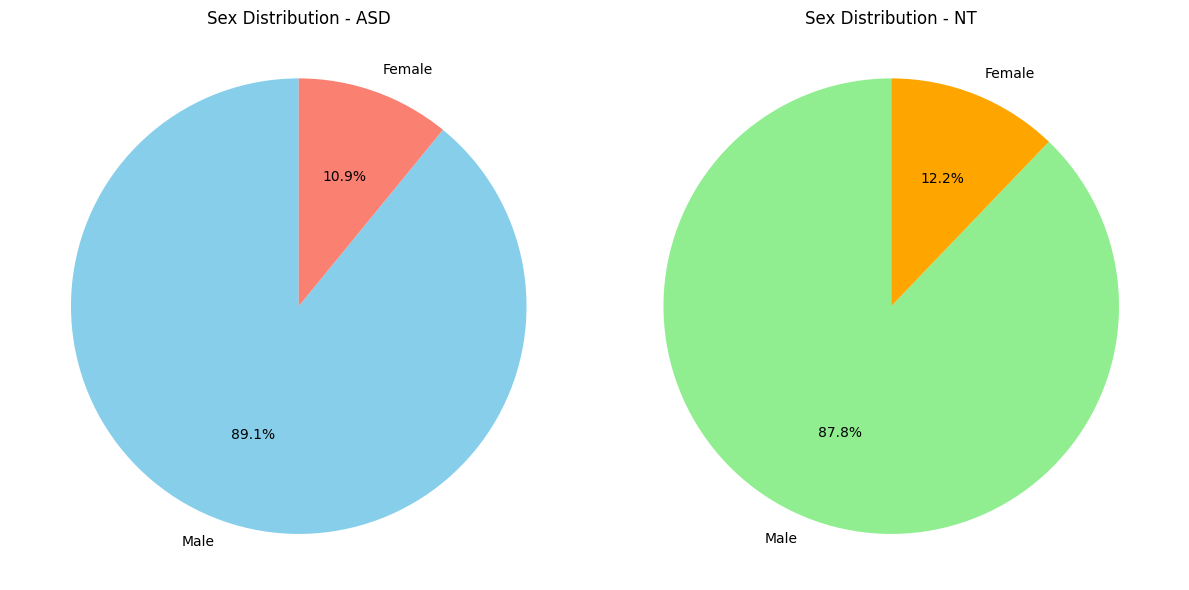

In [26]:
# Example data (you already have these)
sex_asd = filtered_data_asd['Sex'].tolist()
sex_nt = filtered_data_nt['Sex'].tolist()

# Count males and females (1.0 is male, 2.0 is female)
sex_count_asd = {1.0: sex_asd.count(1.0), 2.0: sex_asd.count(2.0)}
sex_count_nt = {1.0: sex_nt.count(1.0), 2.0: sex_nt.count(2.0)}

# Prepare the labels and values for each pie chart
labels = ['Male', 'Female']
sizes_asd = [sex_count_asd[1.0], sex_count_asd[2.0]]
sizes_nt = [sex_count_nt[1.0], sex_count_nt[2.0]]

# Create the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Pie chart for ASD
axes[0].pie(sizes_asd, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon'])
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title('Sex Distribution - ASD')

# Pie chart for NT
axes[1].pie(sizes_nt, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'orange'])
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[1].set_title('Sex Distribution - NT')

# Show the plots
plt.tight_layout()
plt.show()

__Global Efficiency__

In [4]:
!pip install pingouin
from statsmodels.stats.multitest import multipletests


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


__Linear Regression between FIQ and Global Efficiency, with Covariates (Age, Sex and Handedness)__

ASD (Residuals): r=-0.176, p=0.197
NT (Residuals): r=-0.030, p=0.801
ASD (P-Corr): p=0.395
NT (P-Corr): p=0.801


Text(0.05, 0.9, 'R=-0.03, Corrected p=0.801')

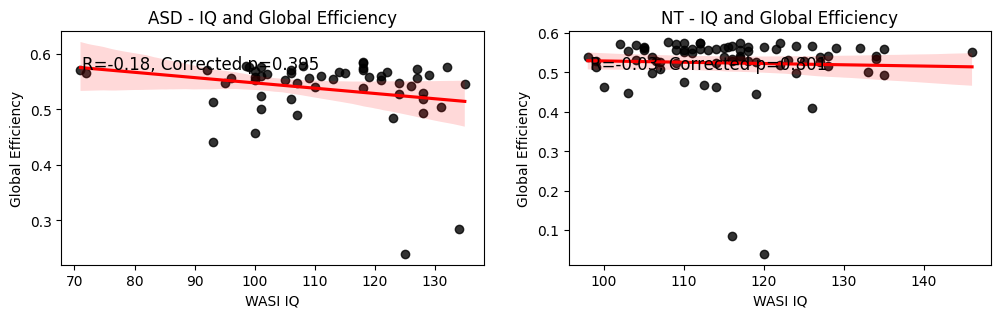

In [5]:
# One-hot encode 'Handedness'
# print(condensed_df_asd['Handedness'])
condensed_df_asd = pd.get_dummies(condensed_df_asd, columns=['Handedness'], drop_first=True)  # Drop one category to avoid multicollinearity
condensed_df_nt = pd.get_dummies(condensed_df_nt, columns=['Handedness'], drop_first=True)


fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])  # 2 rows, 2 columns, adjust ratios as needed

ax1 = fig.add_subplot(gs[0, 0])

p = sns.regplot(x='IQ', y='Global Efficiency', data=condensed_df_asd, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=ax1, fit_reg=True)


ax1.set_title("ASD - IQ and Global Efficiency")
ax1.set_xlabel("WASI IQ")
ax1.set_ylabel("Global Efficiency")

ax2 = fig.add_subplot(gs[0, 1])
sns.regplot(x='IQ', y='Global Efficiency', data=condensed_df_nt, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=ax2, fit_reg=True)
ax2.set_title("NT - IQ and Global Efficiency")
ax2.set_xlabel("WASI IQ")
ax2.set_ylabel("Global Efficiency")

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
# Function to compute residuals
def get_residuals(df, y_var, covariates):
    model = LinearRegression()
    X = df[covariates]
    y = df[y_var]
    model.fit(X, y)
    residuals = y - model.predict(X)
    return residuals

# Define covariates
covariates_asd = ['Age', 'Sex'] + [col for col in condensed_df_asd.columns if col.startswith('Handedness_')]
covariates_nt = ['Age', 'Sex'] + [col for col in condensed_df_nt.columns if col.startswith('Handedness_')]

# ASD group
residuals_asd_global_eff = get_residuals(condensed_df_asd, 'Global Efficiency', covariates_asd)
residuals_asd_iq = get_residuals(condensed_df_asd, 'IQ', covariates_asd)
r_asd, p_asd = pearsonr(residuals_asd_iq, residuals_asd_global_eff)

# NT group
residuals_nt_global_eff = get_residuals(condensed_df_nt, 'Global Efficiency', covariates_nt)
residuals_nt_iq = get_residuals(condensed_df_nt, 'IQ', covariates_nt)
r_nt, p_nt = pearsonr(residuals_nt_iq, residuals_nt_global_eff)

# Print results
print(f"ASD (Residuals): r={r_asd:.3f}, p={p_asd:.3f}")
print(f"NT (Residuals): r={r_nt:.3f}, p={p_nt:.3f}")

# Adjust p-values for multiple comparisons
p_values = [p_asd, p_nt]
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

p_asd_corrected, p_nt_corrected = corrected_p_values

print(f"ASD (P-Corr): p={p_asd_corrected:.3f}")
print(f"NT (P-Corr): p={p_nt_corrected:.3f}")
# Add results to plots
ax1.text(0.05, 0.90, f'R={r_asd:.2f}, Corrected p={p_asd_corrected:.3f}', 
         transform=ax1.transAxes, fontsize=12, verticalalignment='top')
ax2.text(0.05, 0.90, f'R={r_nt:.2f}, Corrected p={p_nt_corrected:.3f}', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top')

ASD: r=-0.220, p=0.107
NT: r=-0.038, p=0.745
ASD (P-Corr): p=0.213
NT (P-Corr): p=0.745


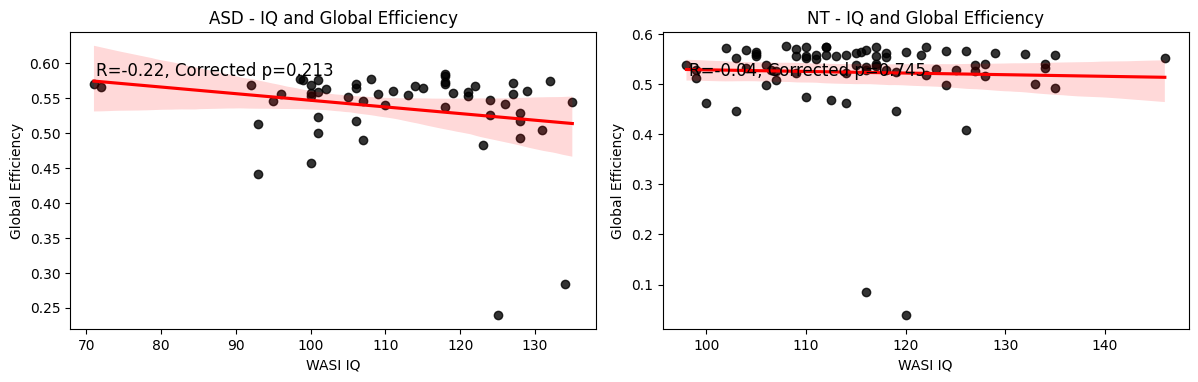

In [8]:
# Plot settings
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])  # 2 rows, 2 columns, adjust ratios as needed

# ASD group plot
ax1 = fig.add_subplot(gs[0, 0])
sns.regplot(x='IQ', y='Global Efficiency', data=condensed_df_asd, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=ax1, fit_reg=True)
ax1.set_title("ASD - IQ and Global Efficiency")
ax1.set_xlabel("WASI IQ")
ax1.set_ylabel("Global Efficiency")

# NT group plot
ax2 = fig.add_subplot(gs[0, 1])
sns.regplot(x='IQ', y='Global Efficiency', data=condensed_df_nt, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=ax2, fit_reg=True)
ax2.set_title("NT - IQ and Global Efficiency")
ax2.set_xlabel("WASI IQ")
ax2.set_ylabel("Global Efficiency")

# Compute Pearson correlation directly
from scipy.stats import pearsonr

# ASD group
r_asd, p_asd = pearsonr(condensed_df_asd['IQ'], condensed_df_asd['Global Efficiency'])

# NT group
r_nt, p_nt = pearsonr(condensed_df_nt['IQ'], condensed_df_nt['Global Efficiency'])

# Print results
print(f"ASD: r={r_asd:.3f}, p={p_asd:.3f}")
print(f"NT: r={r_nt:.3f}, p={p_nt:.3f}")

# Adjust p-values for multiple comparisons
from statsmodels.stats.multitest import multipletests
p_values = [p_asd, p_nt]
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

p_asd_corrected, p_nt_corrected = corrected_p_values

print(f"ASD (P-Corr): p={p_asd_corrected:.3f}")
print(f"NT (P-Corr): p={p_nt_corrected:.3f}")
# Add results to plots
ax1.text(0.05, 0.90, f'R={r_asd:.2f}, Corrected p={p_asd_corrected:.3f}', 
         transform=ax1.transAxes, fontsize=12, verticalalignment='top')
ax2.text(0.05, 0.90, f'R={r_nt:.2f}, Corrected p={p_nt_corrected:.3f}', 
         transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()


In [7]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

r_asd, p_asd = pearsonr(condensed_df_asd['IQ'], condensed_df_asd['Global Efficiency'])
print(r_asd, p_asd)

r_nt, p_nt = pearsonr(condensed_df_nt['IQ'], condensed_df_nt['Global Efficiency'])
print(r_nt, p_nt)
# Collect p-values
p_values = [p_asd, p_nt]

# Apply Bonferroni correction
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Unpack corrected p-values
p_asd_corrected, p_nt_corrected = corrected_p_values

print(p_asd_corrected)

X = condensed_df_asd[['IQ', 'Age', 'Sex']]
y = condensed_df_asd['Global Efficiency']

scaler_X = StandardScaler()
X_standardized = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Add a constant to the predictors
X_standardized_with_const = sm.add_constant(X_standardized)

# Fit the regression model with standardized variables
model = sm.OLS(y_standardized, X_standardized_with_const).fit()

# Get standardized coefficients
slope_IQ_std = model.params[1]
slope_Age_std = model.params[2]
slope_Sex_std = model.params[3]
intercept_std = model.params[0]

print("NT Regression")
print(f"Standardized Slope for IQ: {slope_IQ_std:.4f}")
print(f"Standardized Slope for Age: {slope_Age_std:.4f}")
print(f"Standardized Slope for Sex: {slope_Sex_std:.4f}")
print(f"Standardized Intercept: {intercept_std:.4f}")

-0.21997144910122696 0.10658907774190356
-0.03849983277253376 0.7446736825158864
0.2131781554838071
NT Regression
Standardized Slope for IQ: -0.1736
Standardized Slope for Age: -0.1601
Standardized Slope for Sex: -0.1190
Standardized Intercept: 0.0000


__Average Clustering__

Text(0, 0.5, 'Average Clustering')

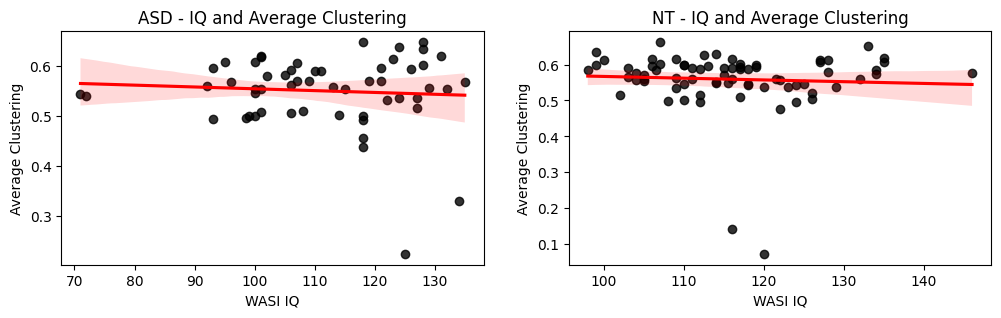

In [23]:
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, height_ratios=[1, 2], width_ratios=[1, 1])  # 2 rows, 2 columns, adjust ratios as needed

ax1 = fig.add_subplot(gs[0, 0])

p = sns.regplot(x='IQ', y='Average Clustering', data=condensed_df_asd, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=ax1, fit_reg=True)

ax1.set_title("ASD - IQ and Average Clustering")
ax1.set_xlabel("WASI IQ")
ax1.set_ylabel("Average Clustering")

ax2 = fig.add_subplot(gs[0, 1])
sns.regplot(x='IQ', y='Average Clustering', data=condensed_df_nt, scatter_kws={"color": "black"}, line_kws={"color": "red"}, ax=ax2, fit_reg=True)
ax2.set_title("NT - IQ and Average Clustering")
ax2.set_xlabel("WASI IQ")
ax2.set_ylabel("Average Clustering")


__Degree Distribution__

Max deg cen asd: 0.30404092071611255
Min deg cen asd: 0.041209021157870215
Max deg cen nt: 0.3457454897352596
Min deg cen nt: 0.032646713209373006


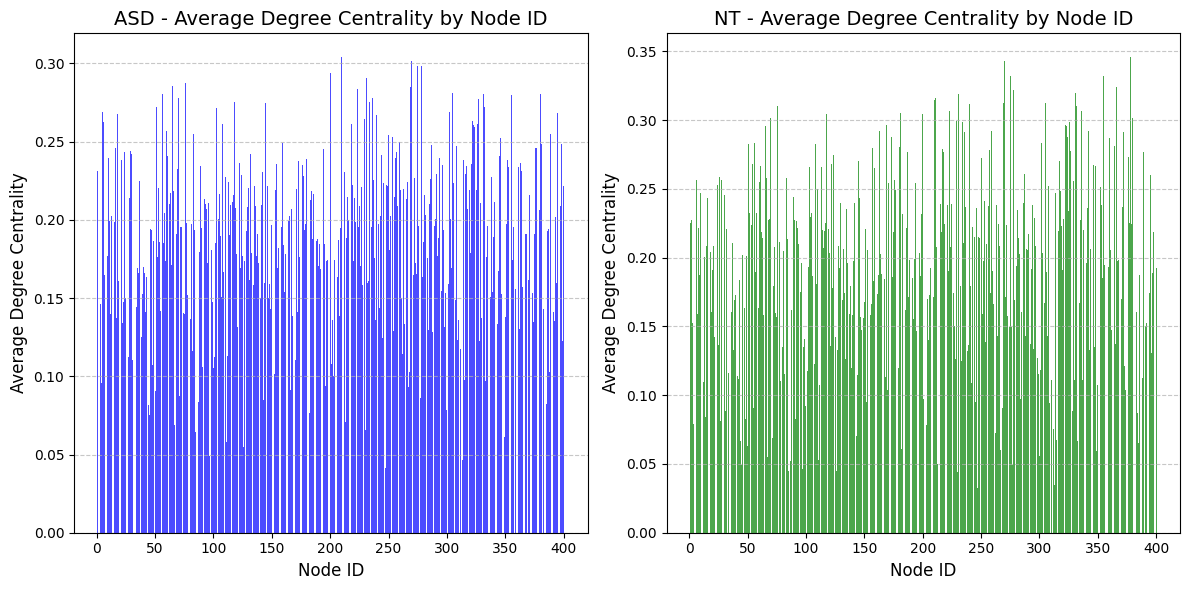

In [33]:
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()



print(f"Max deg cen asd: {max(average_degree_centrality_asd.values)}")
print(f"Min deg cen asd: {min(average_degree_centrality_asd.values)}")


print(f"Max deg cen nt: {max(average_degree_centrality_nt.values)}")
print(f"Min deg cen nt: {min(average_degree_centrality_nt.values)}")

# Set up the figure with GridSpec
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1])  # 1 row, 2 columns

# Plot ASD histogram
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(average_degree_centrality_asd.index, average_degree_centrality_asd.values, color='blue', alpha=0.7)
ax1.set_title("ASD - Average Degree Centrality by Node ID", fontsize=14)
ax1.set_xlabel("Node ID", fontsize=12)
ax1.set_ylabel("Average Degree Centrality", fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Plot NT histogram
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(average_degree_centrality_nt.index, average_degree_centrality_nt.values, color='green', alpha=0.7)
ax2.set_title("NT - Average Degree Centrality by Node ID", fontsize=14)
ax2.set_xlabel("Node ID", fontsize=12)
ax2.set_ylabel("Average Degree Centrality", fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

__Degree Distribution__

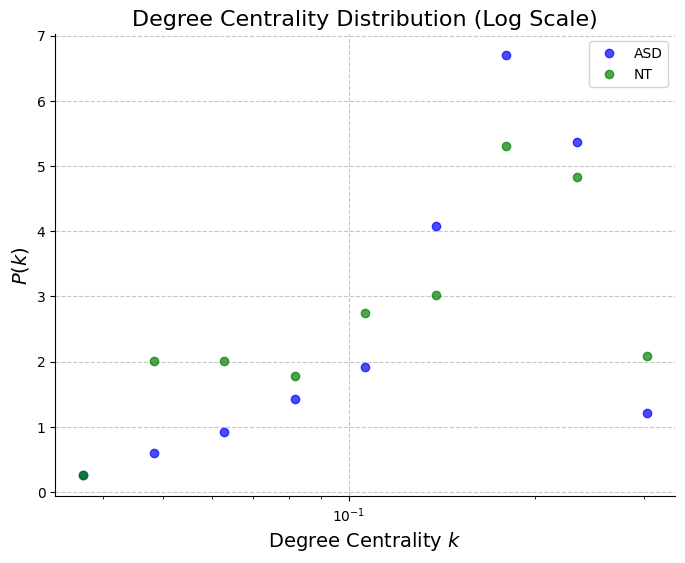

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'average_degree_centrality_asd' and 'average_degree_centrality_nt' are already defined

# Extract degree centrality values
degrees_asd = average_degree_centrality_asd.values
degrees_nt = average_degree_centrality_nt.values

# Define logarithmically spaced bins
kmin = min(np.min(degrees_asd), np.min(degrees_nt))
kmax = max(np.max(degrees_asd), np.max(degrees_nt))
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# Compute histogram densities
density_asd, _ = np.histogram(degrees_asd, bins=bin_edges, density=True)
density_nt, _ = np.histogram(degrees_nt, bins=bin_edges, density=True)

# Compute midpoints in log-space
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1]) / 2)

# Plot the degree centrality distributions
plt.figure(figsize=(8, 6))
plt.plot(x, density_asd, marker='o', linestyle='none', label='ASD', color='blue', alpha=0.7)
plt.plot(x, density_nt, marker='o', linestyle='none', label='NT', color='green', alpha=0.7)

# Customize plot appearance
plt.xscale('log')  # Logarithmic x-axis for better visualization
plt.xlabel(r"Degree Centrality $k$", fontsize=14)
plt.ylabel(r"$P(k)$", fontsize=14)
plt.title("Degree Centrality Distribution (Log Scale)", fontsize=16)
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Remove top and right spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Show the plot
plt.show()


__Hubs__

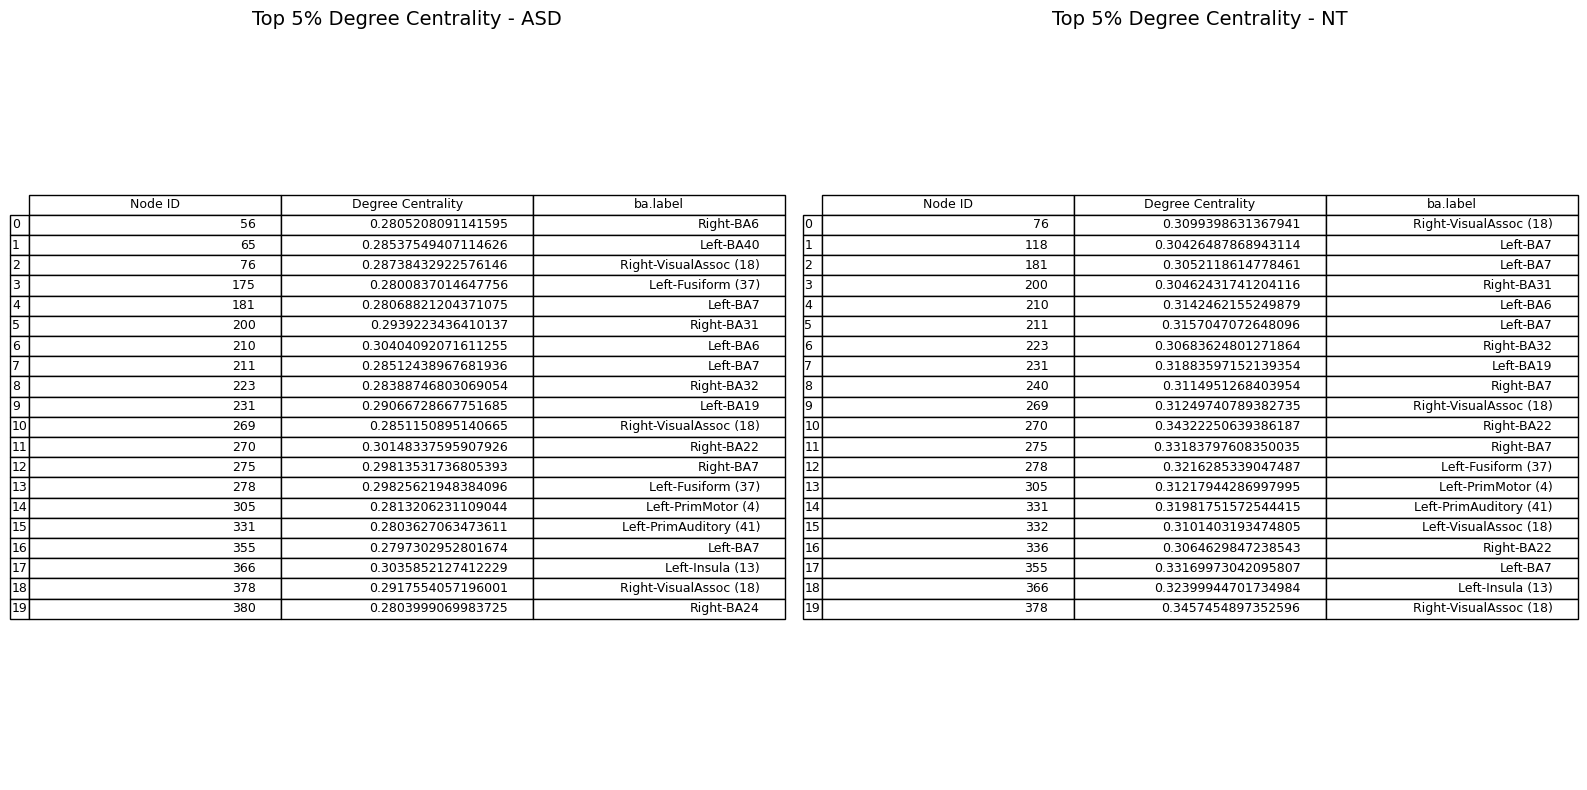

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# Get top 5% degree centrality values for ASD
top_percent_value_asd = average_degree_centrality_asd.quantile(0.95)
top_percent_df_asd = average_degree_centrality_asd[average_degree_centrality_asd >= top_percent_value_asd]

# Get top 5% degree centrality values for NT (you can change the percentage if needed)
top_percent_value_nt = average_degree_centrality_nt.quantile(0.95)
top_percent_df_nt = average_degree_centrality_nt[average_degree_centrality_nt >= top_percent_value_nt]

top_nodes_asd = list(top_percent_df_asd.to_dict().keys())
top_nodes_nt = list(top_percent_df_nt.to_dict().keys())

# Map BA labels to top nodes (for ASD)
top_nodes_ba_map_asd = {}
for node in top_nodes_asd:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    top_nodes_ba_map_asd[node] = ba_label_value

# Map BA labels to top nodes (for NT)
top_nodes_ba_map_nt = {}
for node in top_nodes_nt:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    top_nodes_ba_map_nt[node] = ba_label_value

# Add the 'ba.label' to the DataFrame (ASD)
top_percent_df_asd = top_percent_df_asd.reset_index()  # Make sure the 'Node ID' becomes a column
top_percent_df_asd['ba.label'] = top_percent_df_asd['Node ID'].map(top_nodes_ba_map_asd)

# Add the 'ba.label' to the DataFrame (NT)
top_percent_df_nt = top_percent_df_nt.reset_index()  # Make sure the 'Node ID' becomes a column
top_percent_df_nt['ba.label'] = top_percent_df_nt['Node ID'].map(top_nodes_ba_map_nt)

# Create subplots with two axes (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Plot the first table (ASD)
axes[0].axis('off')
table_asd = pd.plotting.table(axes[0], top_percent_df_asd, loc='center')

# Plot the second table (NT)
axes[1].axis('off')
table_nt = pd.plotting.table(axes[1], top_percent_df_nt, loc='center')

axes[0].set_title('Top 5% Degree Centrality - ASD', fontsize=14)
axes[1].set_title('Top 5% Degree Centrality - NT', fontsize=14)
# Adjust layout to make sure everything fits well
plt.tight_layout()
plt.show()


__Shared Hubs__

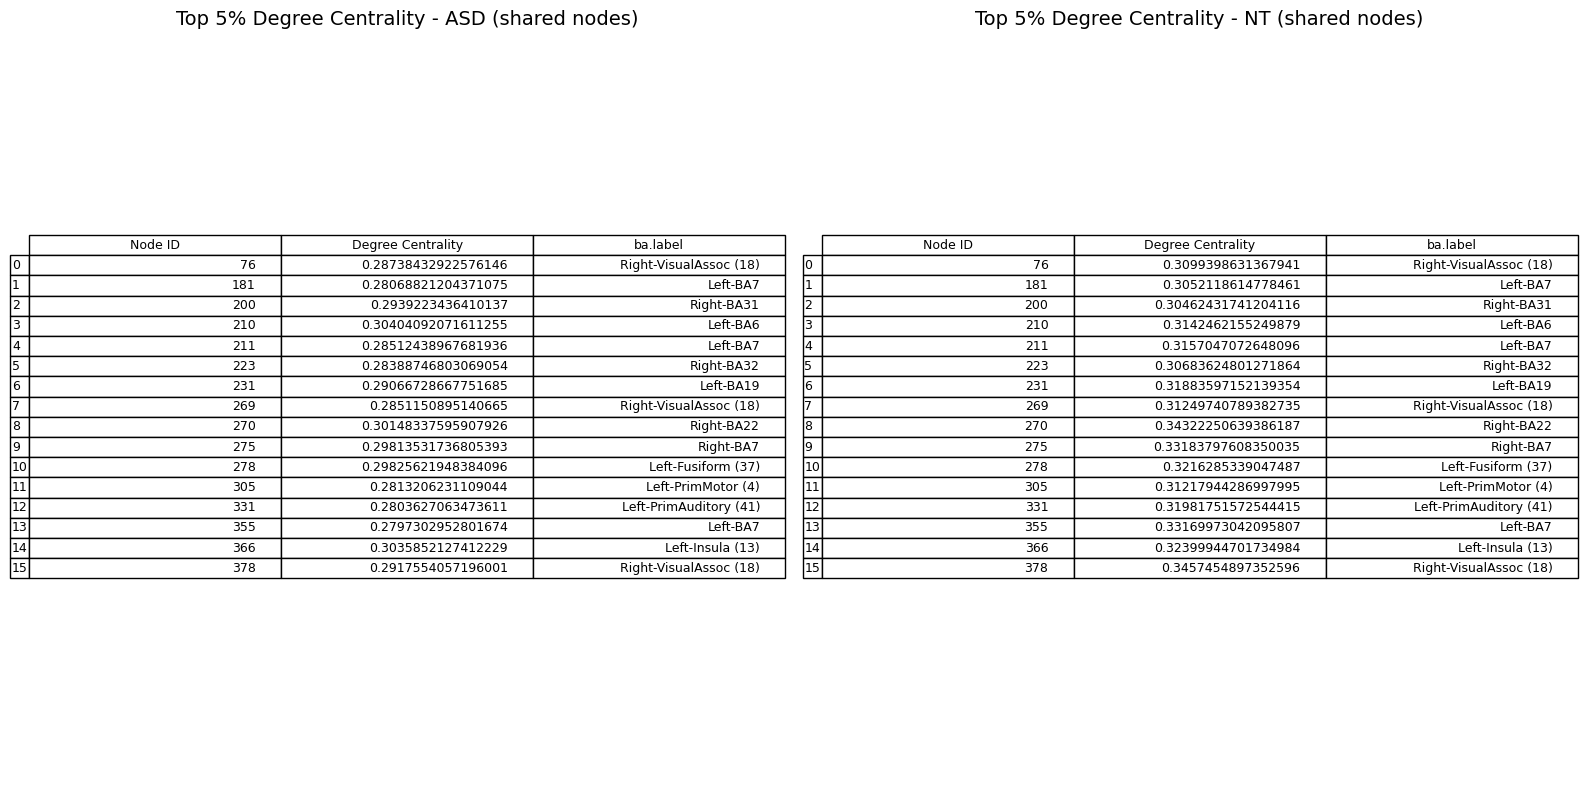

In [97]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# Get top 5% degree centrality values for ASD
top_percent_value_asd = average_degree_centrality_asd.quantile(0.95)
top_percent_df_asd = average_degree_centrality_asd[average_degree_centrality_asd >= top_percent_value_asd]

# Get top 5% degree centrality values for NT (you can change the percentage if needed)
top_percent_value_nt = average_degree_centrality_nt.quantile(0.95)
top_percent_df_nt = average_degree_centrality_nt[average_degree_centrality_nt >= top_percent_value_nt]

# Find common Node IDs between ASD and NT
common_nodes = top_percent_df_asd.index.intersection(top_percent_df_nt.index)

# Filter ASD and NT data to only include common nodes
top_percent_df_asd = top_percent_df_asd.loc[common_nodes]
top_percent_df_nt = top_percent_df_nt.loc[common_nodes]

# Map BA labels to top nodes (for ASD)
top_nodes_ba_map_asd = {}
for node in common_nodes:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    top_nodes_ba_map_asd[node] = ba_label_value

# Map BA labels to top nodes (for NT)
top_nodes_ba_map_nt = {}
for node in common_nodes:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    top_nodes_ba_map_nt[node] = ba_label_value

# Add the 'ba.label' to the DataFrame (ASD)
top_percent_df_asd = top_percent_df_asd.reset_index()  # Make sure the 'Node ID' becomes a column
top_percent_df_asd['ba.label'] = top_percent_df_asd['Node ID'].map(top_nodes_ba_map_asd)

# Add the 'ba.label' to the DataFrame (NT)
top_percent_df_nt = top_percent_df_nt.reset_index()  # Make sure the 'Node ID' becomes a column
top_percent_df_nt['ba.label'] = top_percent_df_nt['Node ID'].map(top_nodes_ba_map_nt)

# Create subplots with two axes (side by side)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns

# Plot the first table (ASD)
axes[0].axis('off')
table_asd = pd.plotting.table(axes[0], top_percent_df_asd, loc='center')

# Plot the second table (NT)
axes[1].axis('off')
table_nt = pd.plotting.table(axes[1], top_percent_df_nt, loc='center')

axes[0].set_title('Top 5% Degree Centrality - ASD (shared nodes)', fontsize=14)
axes[1].set_title('Top 5% Degree Centrality - NT (shared nodes)', fontsize=14)
# Adjust layout to make sure everything fits well
plt.tight_layout()
plt.show()


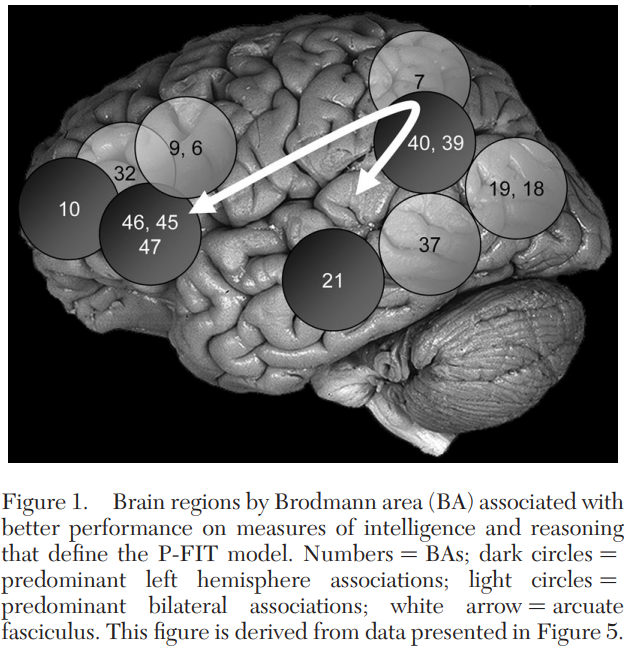

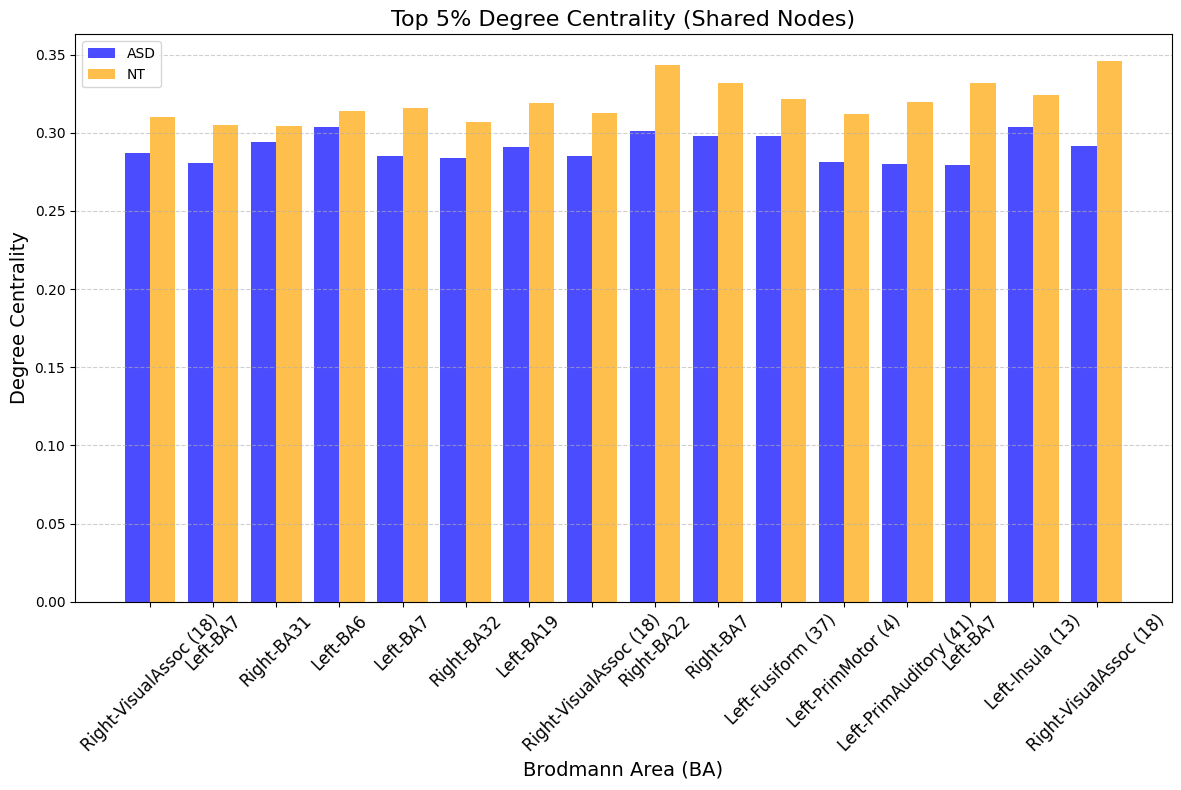

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# Get top 5% degree centrality values for ASD
top_percent_value_asd = average_degree_centrality_asd.quantile(0.95)
top_percent_df_asd = average_degree_centrality_asd[average_degree_centrality_asd >= top_percent_value_asd]

# Get top 5% degree centrality values for NT
top_percent_value_nt = average_degree_centrality_nt.quantile(0.95)
top_percent_df_nt = average_degree_centrality_nt[average_degree_centrality_nt >= top_percent_value_nt]

# Find common Node IDs between ASD and NT
common_nodes = top_percent_df_asd.index.intersection(top_percent_df_nt.index)

# Filter ASD and NT data to only include common nodes
top_percent_df_asd = top_percent_df_asd.loc[common_nodes]
top_percent_df_nt = top_percent_df_nt.loc[common_nodes]

# Map BA labels to top nodes (for ASD)
top_nodes_ba_map = {}
for node in common_nodes:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    top_nodes_ba_map[node] = ba_label_value

# Add the 'ba.label' to the DataFrame
labels = [top_nodes_ba_map[node] for node in common_nodes]
asd_values = top_percent_df_asd.values
nt_values = top_percent_df_nt.values

# Create a double bar chart
x = np.arange(len(common_nodes))  # Numeric positions for bars
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for ASD and NT
bars_asd = ax.bar(x - width/2, asd_values, width, label='ASD', color='blue', alpha=0.7)
bars_nt = ax.bar(x + width/2, nt_values, width, label='NT', color='orange', alpha=0.7)

# Adding labels, title, and legend
ax.set_xlabel('Brodmann Area (BA)', fontsize=14)
ax.set_ylabel('Degree Centrality', fontsize=14)
ax.set_title('Top 5% Degree Centrality (Shared Nodes)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation=45)
ax.legend()

# Show grid and tighten layout
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


__Based on intelligence selected regions__

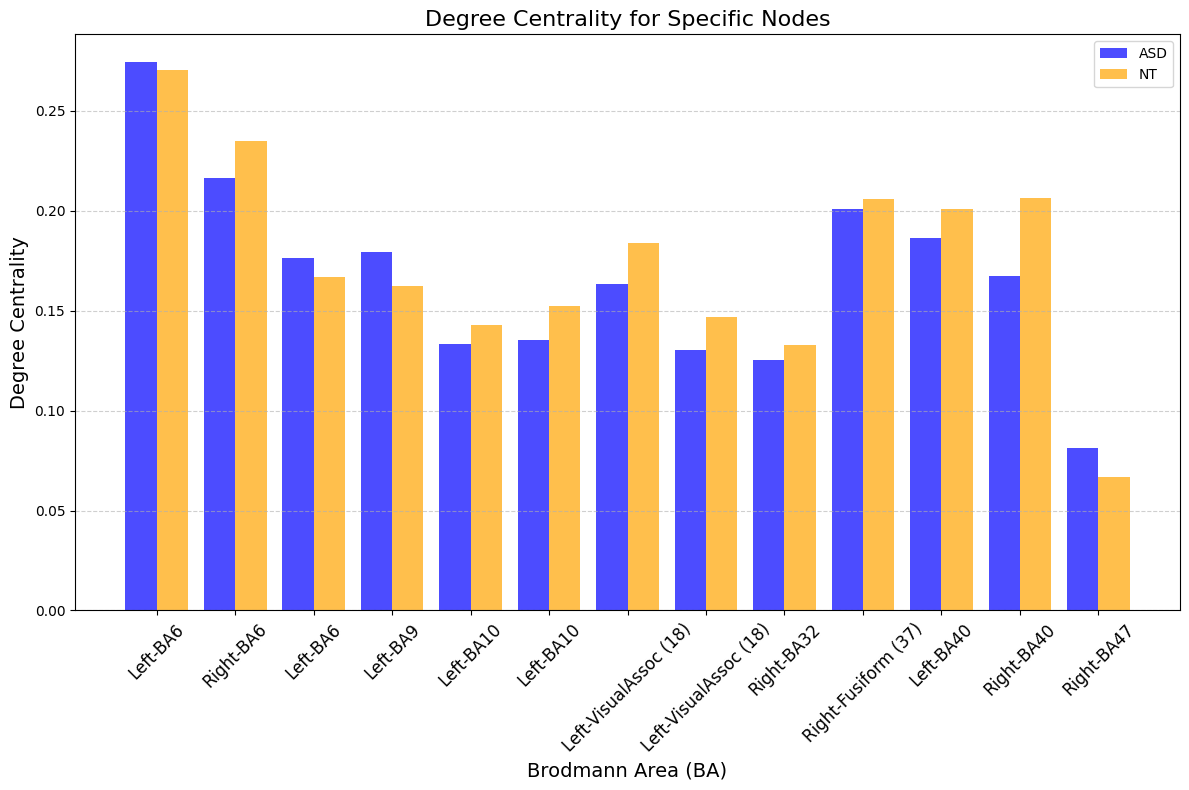

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# List of specific nodes
specific_nodes = [145, 281, 334, 88, 264, 392, 43, 362, 38, 290, 49, 344, 44]

# Filter data to only include specific nodes
specific_nodes_asd = average_degree_centrality_asd.loc[specific_nodes]
specific_nodes_nt = average_degree_centrality_nt.loc[specific_nodes]

# Map BA labels to specific nodes
specific_nodes_ba_map = {}
for node in specific_nodes:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    specific_nodes_ba_map[node] = ba_label_value

# Add the 'ba.label' to the DataFrame
labels = [specific_nodes_ba_map[node] for node in specific_nodes]
asd_values = specific_nodes_asd.values
nt_values = specific_nodes_nt.values

# Create a double bar chart
x = np.arange(len(specific_nodes))  # Numeric positions for bars
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for ASD and NT
bars_asd = ax.bar(x - width/2, asd_values, width, label='ASD', color='blue', alpha=0.7)
bars_nt = ax.bar(x + width/2, nt_values, width, label='NT', color='orange', alpha=0.7)

# Adding labels, title, and legend
ax.set_xlabel('Brodmann Area (BA)', fontsize=14)
ax.set_ylabel('Degree Centrality', fontsize=14)
ax.set_title('Degree Centrality for Specific Nodes', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12, rotation=45)
ax.legend()

# Show grid and tighten layout
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


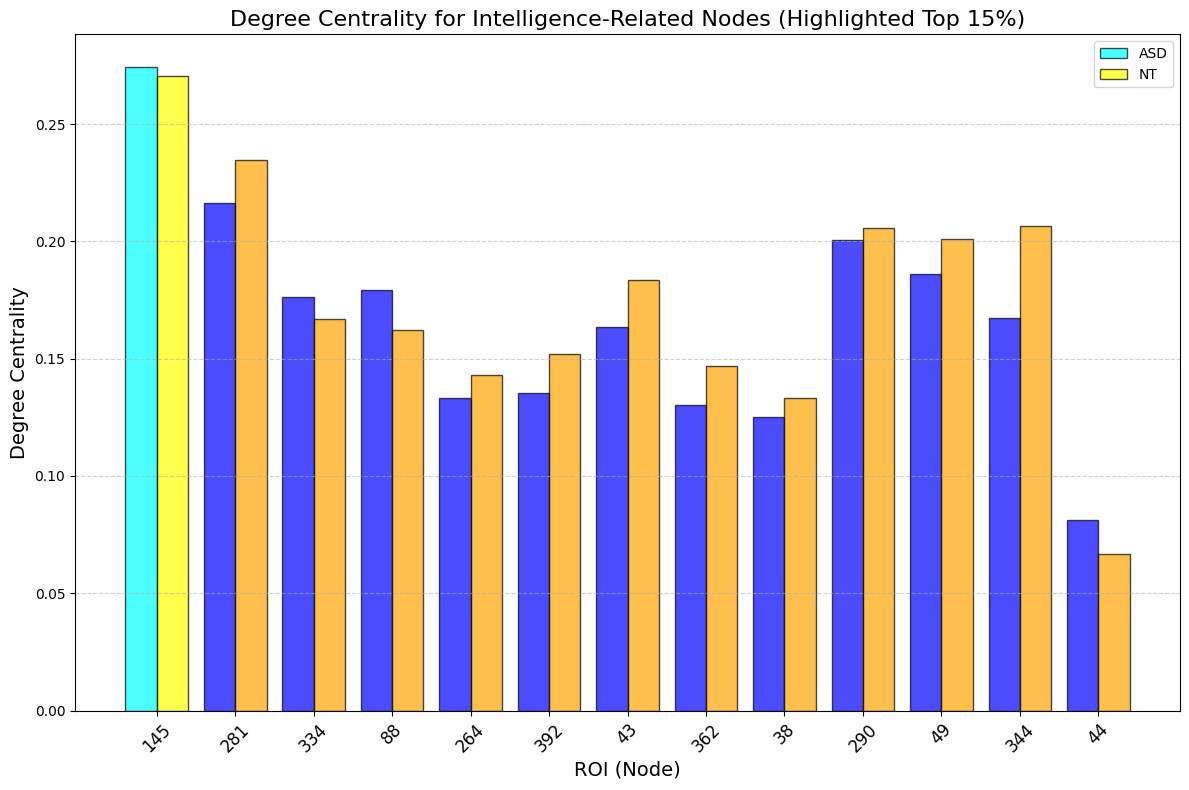

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# List of specific nodes
specific_nodes = sorted([145, 281, 334, 88, 264, 392, 43, 362, 38, 290, 49, 344, 44])

# Top 5% Degree Centrality Thresholds
top_percent_value_asd = average_degree_centrality_asd.quantile(0.85)
top_percent_value_nt = average_degree_centrality_nt.quantile(0.85)

# Identify specific nodes in the top 5%
highlight_asd = [node in average_degree_centrality_asd.index and average_degree_centrality_asd[node] >= top_percent_value_asd for node in specific_nodes]
highlight_nt = [node in average_degree_centrality_nt.index and average_degree_centrality_nt[node] >= top_percent_value_nt for node in specific_nodes]

# Filter data to only include specific nodes
specific_nodes_asd = average_degree_centrality_asd.loc[specific_nodes]
specific_nodes_nt = average_degree_centrality_nt.loc[specific_nodes]

# Map BA labels to specific nodes
specific_nodes_ba_map = {}
for node in specific_nodes:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    specific_nodes_ba_map[node] = ba_label_value

# Add the 'ba.label' to the DataFrame
labels = [specific_nodes_ba_map[node] for node in specific_nodes]
asd_values = specific_nodes_asd.values
nt_values = specific_nodes_nt.values

# Create a double bar chart
x = np.arange(len(specific_nodes))  # Numeric positions for bars
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for ASD
bars_asd = ax.bar(
    x - width/2, 
    asd_values, 
    width, 
    label='ASD', 
    color=['blue' if not highlight else 'cyan' for highlight in highlight_asd], 
    alpha=0.7,
    edgecolor=['black' if highlight else 'none' for highlight in highlight_asd]
)

# Bars for NT
bars_nt = ax.bar(
    x + width/2, 
    nt_values, 
    width, 
    label='NT', 
    color=['orange' if not highlight else 'yellow' for highlight in highlight_nt], 
    alpha=0.7,
    edgecolor=['black' if highlight else 'none' for highlight in highlight_nt]
)

# Adding labels, title, and legend
ax.set_xlabel('ROI (Node)', fontsize=14)
ax.set_ylabel('Degree Centrality', fontsize=14)
ax.set_title('Degree Centrality for Intelligence-Related Nodes (Highlighted Top 15%)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(specific_nodes, fontsize=12, rotation=45)
ax.legend()

# Show grid and tighten layout
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


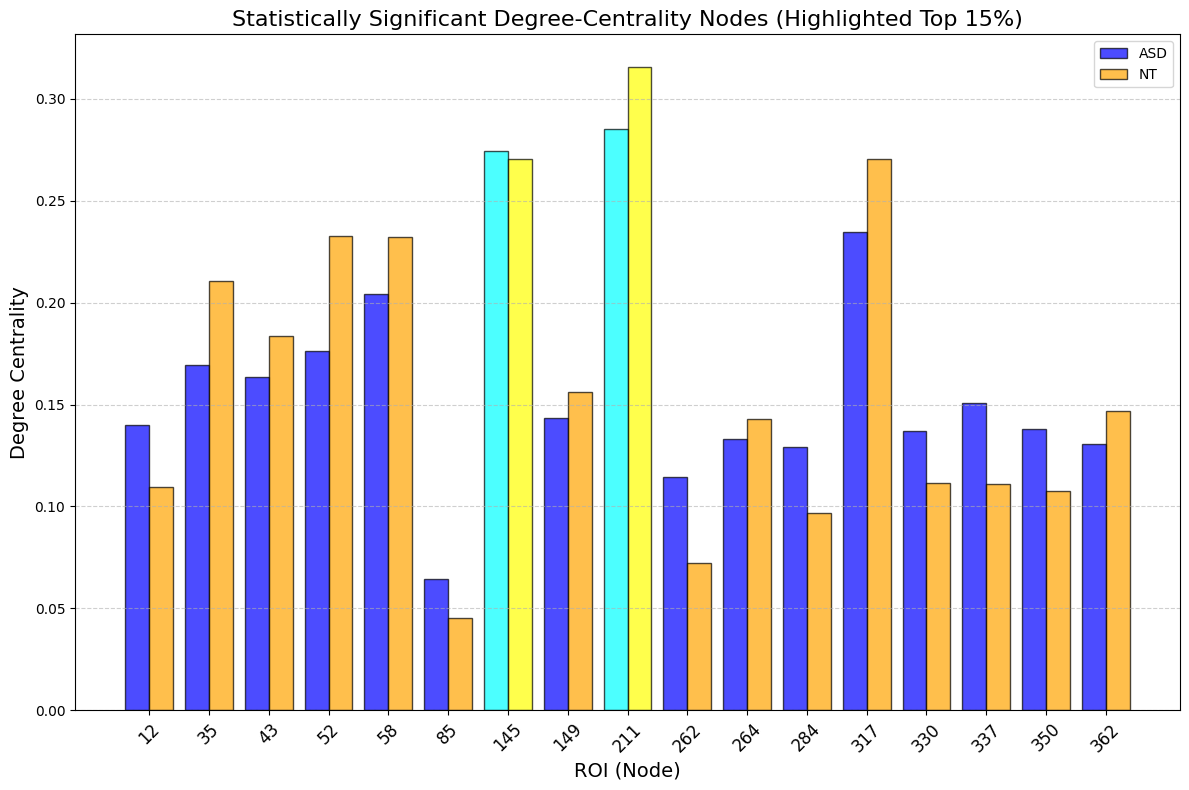

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# List of specific nodes
specific_nodes = [12, 35, 43, 52, 58, 85, 145, 149, 211, 262, 264, 284, 317, 330, 337, 350, 362]

# Top 5% Degree Centrality Thresholds
top_percent_value_asd = average_degree_centrality_asd.quantile(0.85)
top_percent_value_nt = average_degree_centrality_nt.quantile(0.85)

# Identify specific nodes in the top 5%
highlight_asd = [node in average_degree_centrality_asd.index and average_degree_centrality_asd[node] >= top_percent_value_asd for node in specific_nodes]
highlight_nt = [node in average_degree_centrality_nt.index and average_degree_centrality_nt[node] >= top_percent_value_nt for node in specific_nodes]

# Filter data to only include specific nodes
specific_nodes_asd = average_degree_centrality_asd.loc[specific_nodes]
specific_nodes_nt = average_degree_centrality_nt.loc[specific_nodes]

# Map BA labels to specific nodes
specific_nodes_ba_map = {}
for node in specific_nodes:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    specific_nodes_ba_map[node] = ba_label_value

# Add the 'ba.label' to the DataFrame
labels = [specific_nodes_ba_map[node] for node in specific_nodes]
asd_values = specific_nodes_asd.values
nt_values = specific_nodes_nt.values

# Create a double bar chart
x = np.arange(len(specific_nodes))  # Numeric positions for bars
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for ASD
bars_asd = ax.bar(
    x - width/2, 
    asd_values, 
    width, 
    label='ASD', 
    color=['blue' if not highlight else 'cyan' for highlight in highlight_asd], 
    alpha=0.7,
    edgecolor=['black' if highlight else 'none' for highlight in highlight_asd]
)

# Bars for NT
bars_nt = ax.bar(
    x + width/2, 
    nt_values, 
    width, 
    label='NT', 
    color=['orange' if not highlight else 'yellow' for highlight in highlight_nt], 
    alpha=0.7,
    edgecolor=['black' if highlight else 'none' for highlight in highlight_nt]
)

# Adding labels, title, and legend
ax.set_xlabel('ROI (Node)', fontsize=14)
ax.set_ylabel('Degree Centrality', fontsize=14)
ax.set_title('Statistically Significant Degree-Centrality Nodes (Highlighted Top 15%)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(specific_nodes, fontsize=12, rotation=45)
ax.legend()

# Show grid and tighten layout
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


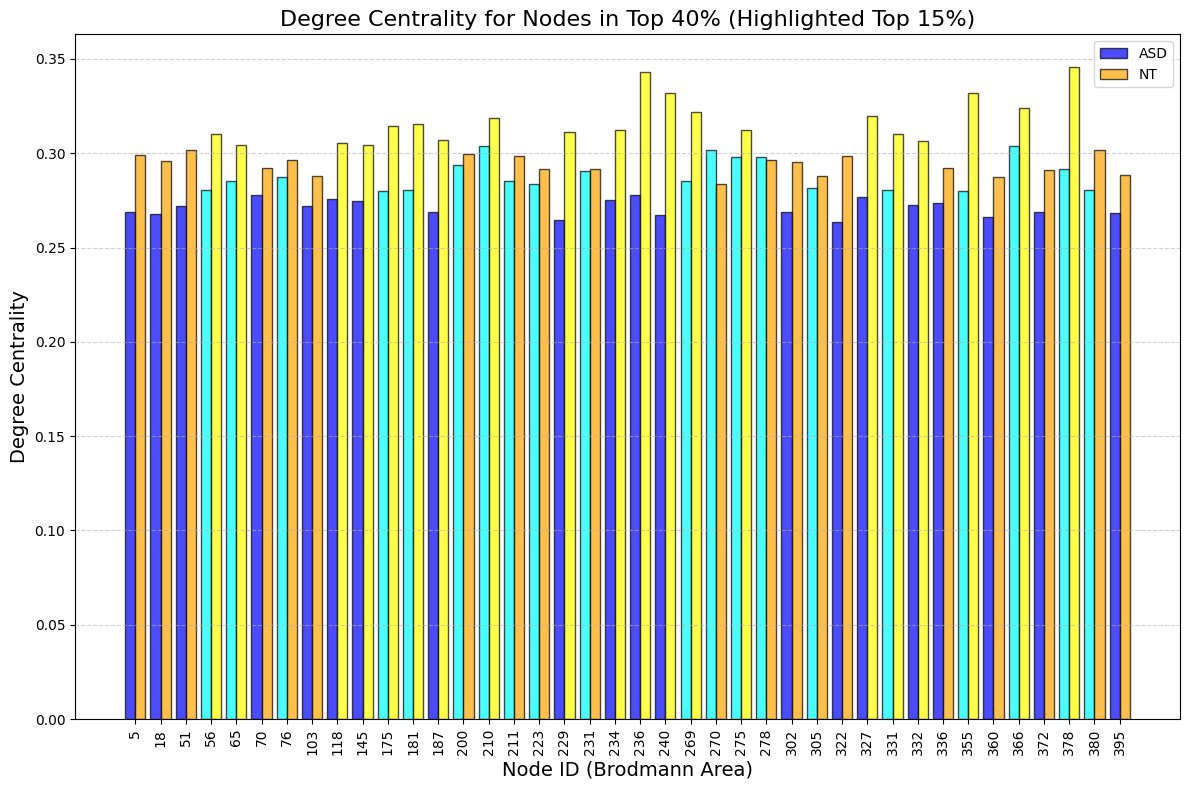

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'filtered_data_asd' and 'filtered_data_nt' are already defined
average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

brodmann_df = pd.read_csv("labeled_regions_ba.csv")

# Calculate top 40% and top 15% degree centrality thresholds
top_40_percent_value_asd = average_degree_centrality_asd.quantile(0.90)
top_40_percent_value_nt = average_degree_centrality_nt.quantile(0.90)

top_15_percent_value_asd = average_degree_centrality_asd.quantile(0.95)
top_15_percent_value_nt = average_degree_centrality_nt.quantile(0.95)

# Identify nodes in the top 40% of degree centrality
top_40_asd = average_degree_centrality_asd >= top_40_percent_value_asd
top_40_nt = average_degree_centrality_nt >= top_40_percent_value_nt

# Identify nodes in the top 15% of degree centrality
top_15_asd = average_degree_centrality_asd >= top_15_percent_value_asd
top_15_nt = average_degree_centrality_nt >= top_15_percent_value_nt

# Filter data to include only nodes that are in the top 40% (for both ASD and NT)
filtered_asd = average_degree_centrality_asd[top_40_asd]
filtered_nt = average_degree_centrality_nt[top_40_nt]

# Map BA labels to nodes
node_ba_map = {}
for node in filtered_asd.index:
    ba_label_value = brodmann_df[brodmann_df['ROI number'] == node]['ba.label'].iloc[0]
    node_ba_map[node] = ba_label_value

# Create lists of degree centrality values for the filtered nodes
asd_values = filtered_asd.values
nt_values = filtered_nt.values
labels = [node_ba_map[node] for node in filtered_asd.index]

# Create a bar chart
x = np.arange(len(filtered_asd))  # Numeric positions for bars
width = 0.4  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

# Bars for ASD
bars_asd = ax.bar(
    x - width/2, 
    asd_values, 
    width, 
    label='ASD', 
    color=['cyan' if highlight else 'blue' for highlight in top_15_asd[filtered_asd.index]],  # Color nodes in top 15%
    alpha=0.7,
    edgecolor=['black' if highlight else 'none' for highlight in top_15_asd[filtered_asd.index]]
)

# Bars for NT
bars_nt = ax.bar(
    x + width/2, 
    nt_values, 
    width, 
    label='NT', 
    color=['yellow' if highlight else 'orange' for highlight in top_15_nt[filtered_nt.index]],  # Color nodes in top 15%
    alpha=0.7,
    edgecolor=['black' if highlight else 'none' for highlight in top_15_nt[filtered_nt.index]]
)

# Adding labels, title, and legend
ax.set_xlabel('Node ID (Brodmann Area)', fontsize=14)
ax.set_ylabel('Degree Centrality', fontsize=14)
ax.set_title('Degree Centrality for Nodes in Top 40% (Highlighted Top 15%)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(filtered_asd.index, fontsize=10, rotation=90)  # Show Node IDs (or Brodmann Area)
ax.legend()

# Show grid and tighten layout
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [54]:
# from nilearn import plotting, datasets, surface
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Load a brain mesh
# fsaverage = datasets.fetch_surf_fsaverage()

# # Load the surface coordinates
# pial_left_coords, _ = surface.load_surf_mesh(fsaverage['pial_left'])  # Load the left hemisphere mesh coordinates

# # Example: average degree centrality data for ASD and NT groups
# average_degree_centrality_asd = filtered_data_asd.groupby("Node ID")['Degree Centrality'].mean()
# average_degree_centrality_nt = filtered_data_nt.groupby("Node ID")['Degree Centrality'].mean()

# # Load the ROI mapping CSV
# mni_mapping = pd.read_csv("CC400_ROI_labels.csv")

# # Function to convert the "center of mass" string to a numeric tuple
# def parse_coordinates(center_of_mass):
#     # Format example: "(-10.5;-49.4;-7.3)"
#     coords = center_of_mass.strip(' ()').split(';')
#     return tuple(map(float, coords))

# # Parse ROI center of mass coordinates
# roi_coordinates = {}
# for _, row in mni_mapping.iterrows():
#     roi_number = row['ROI number']
#     center_of_mass = row[' center of mass']
#     roi_coordinates[roi_number] = parse_coordinates(center_of_mass)

# # Initialize projection arrays for ASD and NT groups
# projection_asd = np.zeros(len(pial_left_coords))
# projection_nt = np.zeros(len(pial_left_coords))

# # Assign degree centrality values to the projection for ASD
# for roi_number, degree_centrality in average_degree_centrality_asd.items():
#     if roi_number in roi_coordinates:
#         coord = np.array(roi_coordinates[roi_number])  # Convert to NumPy array for vectorized computation
#         distances = np.linalg.norm(pial_left_coords - coord, axis=1)  # Calculate distances
#         closest_vertex = np.argmin(distances)  # Find the closest vertex
#         projection_asd[closest_vertex] = degree_centrality

# # Assign degree centrality values to the projection for NT
# for roi_number, degree_centrality in average_degree_centrality_nt.items():
#     if roi_number in roi_coordinates:
#         coord = np.array(roi_coordinates[roi_number])
#         distances = np.linalg.norm(pial_left_coords - coord, axis=1)
#         closest_vertex = np.argmin(distances)
#         projection_nt[closest_vertex] = degree_centrality

# # Plotting the degree centrality on the brain surface for ASD and NT
# fig = plt.figure(figsize=(16, 8))

# # Create 3D axes for each plot
# ax_asd = fig.add_subplot(121, projection='3d')
# ax_nt = fig.add_subplot(122, projection='3d')

# # Plot for ASD group
# plotting.plot_surf_stat_map(
#     fsaverage['pial_left'], projection_asd, hemi='left', title='ASD Degree Centrality',
#     colorbar=True, axes=ax_asd, threshold=0, cmap='coolwarm'
# )

# # Plot for NT group
# plotting.plot_surf_stat_map(
#     fsaverage['pial_left'], projection_nt, hemi='left', title='NT Degree Centrality',
#     colorbar=True, axes=ax_nt, threshold=0, cmap='coolwarm'
# )

# # Show the plots
# plt.tight_layout()
# plt.show()